**Step 1: Import Dependencies**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Step 2: Load Data

In [2]:
ratings = pd.read_csv("./data/ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
movies = pd.read_csv("./data/movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Step 3: Exploratory Data Analysis

In [4]:
n_ratings = len(ratings)
n_movies = movies["movieId"].nunique()
n_users = ratings["userId"].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of unique movieId's: 9742
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.35


What is the distribution of movie ratings?

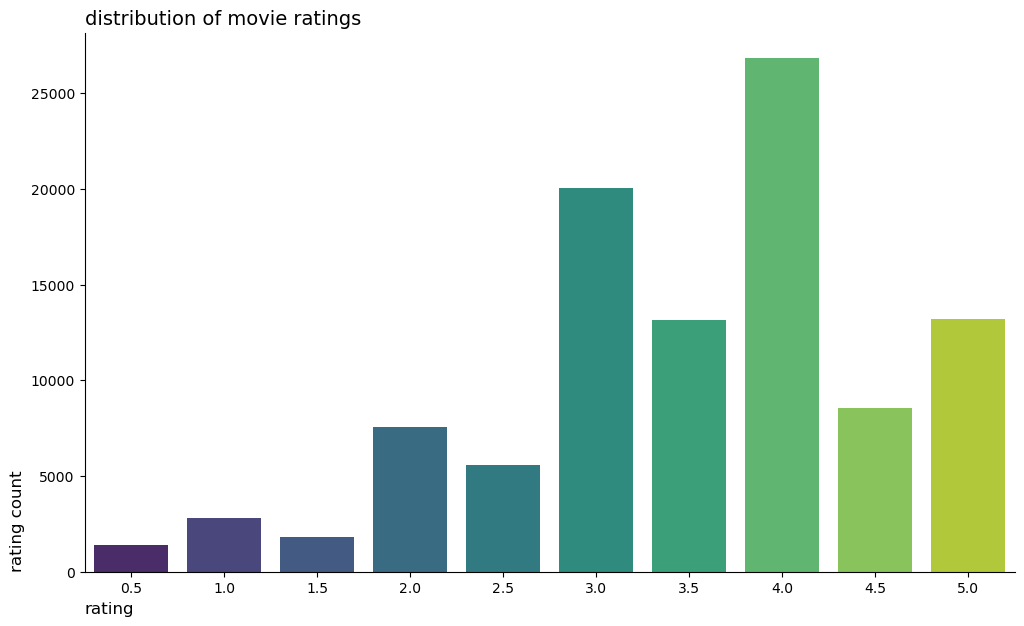

In [5]:
plt.figure(figsize=(12, 7))
sns.countplot(data=ratings, x="rating", palette="viridis")
plt.title("distribution of movie ratings", fontsize=14, loc="left")
plt.xlabel("rating", loc="left", fontsize=12)
plt.ylabel("rating count", loc="bottom", fontsize=12)
plt.gca().spines[["top", "right"]].set_visible(False)
plt.show()

In [6]:
print(f"Mean global rating :{round(ratings['rating'].mean(),2)}")

mean_user_rating = ratings.groupby("userId")["rating"].mean()
print(f"Mean rating per user : {round(mean_user_rating.mean(),2)}")

Mean global rating :3.5
Mean rating per user : 3.66


Which movies are most frequently rated?

In [7]:
movie_rating = ratings.merge(movies, on="movieId")
movie_rating.groupby("title")["rating"].count().sort_values(ascending=False)[:10]

title
Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
Star Wars: Episode IV - A New Hope (1977)    251
Jurassic Park (1993)                         238
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            224
Schindler's List (1993)                      220
Name: rating, dtype: int64

Forrest Gump, Shawshank Redemption, and Pulp Fiction have the most ratings.

# What are the lowest and highest rated movies?

Which movie has the lowest and highest average rating?

In [8]:
mean_ratings = ratings.groupby("movieId")[["rating"]].mean()
lower_rated = mean_ratings["rating"].idxmin()

movies[movies["movieId"] == lower_rated]

,movieId,title,genres
2689,3604,Gypsy (1962),Musical


Gypsy has the lowest average rating.

In [9]:
highest_rated = mean_ratings["rating"].idxmax()

movies[movies["movieId"] == highest_rated]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


How many ratings does Lamerica have?

In [10]:
ratings[ratings["movieId"] == highest_rated]

,userId,movieId,rating,timestamp
13368,85,53,5.0,889468268
96115,603,53,5.0,963180003



Lamerica may be the "highest" rated movie, but it only has 2 ratings. A better approach for evaluating movie popularity is to do look at the Bayesian average.

Bayesian Average
Bayesian Average is defined as:

<math xmlns="http://www.w3.org/1998/Math/MathML">
  <msub>
    <mi>r</mi>
    <mrow data-mjx-texclass="ORD">
      <mi>i</mi>
    </mrow>
  </msub>
  <mo>=</mo>
  <mfrac>
    <mrow>
      <mi>C</mi>
      <mo>&#xD7;</mo>
      <mi>m</mi>
      <mo>+</mo>
      <mi mathvariant="normal">&#x3A3;</mi>
      <mrow data-mjx-texclass="ORD">
        <mtext>reviews</mtext>
      </mrow>
    </mrow>
    <mrow>
      <mi>C</mi>
      <mo>+</mo>
      <mi>N</mi>
    </mrow>
  </mfrac>
</math>


Bayesian Average
Bayesian Average is defined as:

 

where C represents our confidence,M represents our prior, and N is the total number of reviews for movie I In this case, our prior M
 will be the average mean rating across all movies. By defintion, C represents "the typical data set size". Let's make C
 be the average number of ratings for a given movie.

In [11]:
movie_stats = ratings.groupby("movieId")["rating"].agg(["count", "mean"])
movie_stats.head()

,count,mean
movieId,,
1,215,3.920930
2,110,3.431818
3,52,3.259615
4,7,2.357143
5,49,3.071429


In [12]:
C = movie_stats["count"].mean()
m = movie_stats["mean"].mean()

print(f"Average number of ratings for a given movie: {C:.2f}")
print(f"Average rating for a given movie: {m:.2f}")


def baysian_avg(ratings):
    baysian_avg = (C * m + ratings.sum()) / (C + ratings.count())
    return round(baysian_avg, 3)

Average number of ratings for a given movie: 10.37
Average rating for a given movie: 3.26


Let's test our bayesian_avg function out on Lamerica:

In [13]:
lamerica = pd.Series([5, 5])
baysian_avg(lamerica)

3.543

Lamerica's average Bayesian rating is 3.5.

Let's now apply bayesian_avg to all movies in our dataset.

In [14]:
baysian_avg_ratings = (
    ratings.groupby("movieId")["rating"].agg(baysian_avg).reset_index()
)
baysian_avg_ratings.columns = ["movieId", "bayesian_avg"]
movie_stats = movie_stats.merge(baysian_avg_ratings, on="movieId")
movie_stats.head()

,movieId,count,mean,bayesian_avg
0,1,215,3.920930,3.891
1,2,110,3.431818,3.417
2,3,52,3.259615,3.260
3,4,7,2.357143,2.898
4,5,49,3.071429,3.105


In [15]:
movie_stats = movie_stats.merge(movies[["movieId", "title"]])
movie_stats.head()

,movieId,count,mean,bayesian_avg,title
0,1,215,3.920930,3.891,Toy Story (1995)
1,2,110,3.431818,3.417,Jumanji (1995)
2,3,52,3.259615,3.260,Grumpier Old Men (1995)
3,4,7,2.357143,2.898,Waiting to Exhale (1995)
4,5,49,3.071429,3.105,Father of the Bride Part II (1995)


In [16]:
movie_stats.sort_values(by="bayesian_avg", ascending=False).head()

,movieId,count,mean,bayesian_avg,title
277,318,317,4.429022,4.392,"Shawshank Redemption, The (1994)"
659,858,192,4.289062,4.236,"Godfather, The (1972)"
2224,2959,218,4.272936,4.227,Fight Club (1999)
224,260,251,4.231076,4.193,Star Wars: Episode IV - A New Hope (1977)
46,50,204,4.237745,4.191,"Usual Suspects, The (1995)"


Using the Bayesian average, we see that Shawshank Redemption, The Godfather, and The Usual Suspects are the most highly rated movies. This result makes much more sense since these movies are critically acclaimed films.

In [17]:
movie_stats.sort_values(by="bayesian_avg", ascending=True).head()

,movieId,count,mean,bayesian_avg,title
1172,1556,19,1.605263,2.190,Speed 2: Cruise Control (1997)
2679,3593,19,1.657895,2.224,Battlefield Earth (2000)
1372,1882,33,1.954545,2.267,Godzilla (1998)
1144,1499,27,1.925926,2.297,Anaconda (1997)
1988,2643,16,1.687500,2.307,Superman IV: The Quest for Peace (1987)


With Bayesian averaging, it looks like Speed 2: Cruise Control, Battlefield Earth, and Godzilla are the worst rated movies. Gypsy isn't so bad after all.

**A Glimpse at Movie Genres**

The movies dataset needs to be cleaned in two ways:

genres is expressed as a string with a pipe | separating each genre. We will manipulate this string into a list, which will make it much easier to analyze.
title currently has (year) appended at the end. We will extract year from each title string and create a new column for it.

In [18]:
movies["genres"] = movies["genres"].apply(lambda x: x.split("|"))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


**How many movie genres are there?**

In [19]:
from collections import Counter

genre_frequency = Counter(g for genres in movies["genres"] for g in genres)
print(f"Qty of Genres {len(genre_frequency)}")
genre_frequency

Qty of Genres 20


Counter({'Drama': 4361,
         'Comedy': 3756,
         'Thriller': 1894,
         'Action': 1828,
         'Romance': 1596,
         'Adventure': 1263,
         'Crime': 1199,
         'Sci-Fi': 980,
         'Horror': 978,
         'Fantasy': 779,
         'Children': 664,
         'Animation': 611,
         'Mystery': 573,
         'Documentary': 440,
         'War': 382,
         'Musical': 334,
         'Western': 167,
         'IMAX': 158,
         'Film-Noir': 87,
         '(no genres listed)': 34})

In [20]:
print(f"most frequent genre top 5 :{genre_frequency.most_common(5)}")

most frequent genre top 5 :[('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596)]


The top 5 genres are: Drama, Comedy, Thriller, Action and Romance.

Let's also visualize genres popularity with a barplot.

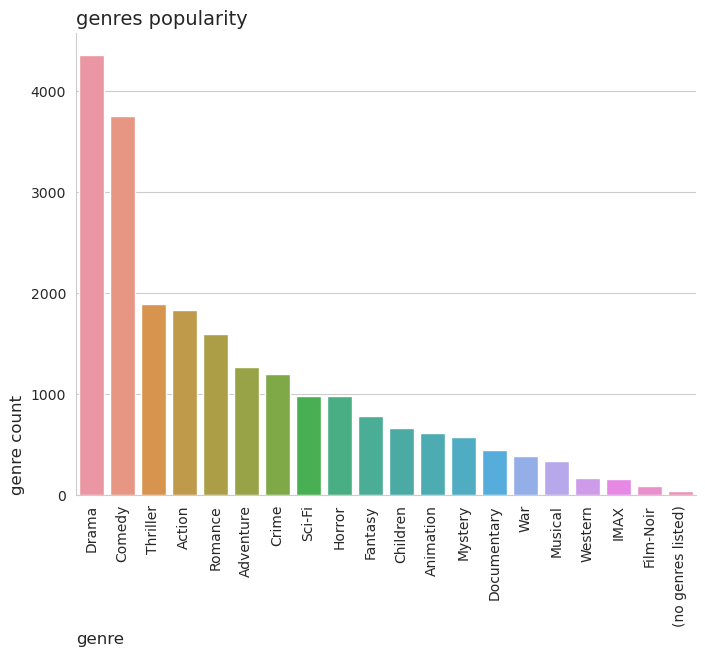

In [21]:
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ["genre", "count"]

sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(
    data=genre_frequency_df.sort_values(by="count", ascending=False),
    x="genre",
    y="count",
)
plt.xticks(rotation=90)
plt.title("genres popularity", fontsize=14, loc="left")
plt.xlabel("genre", loc="left", fontsize=12)
plt.ylabel("genre count", loc="bottom", fontsize=12)
plt.gca().spines[["top", "right"]].set_visible(False)
plt.show()

# Step 4: Data Pre-processing
We are going to use a technique called colaborative filtering to generate recommendations for users. This technique is based on the premise that similar people like similar things.

The first step is to transform our data into a user-item matrix, also known as a "utility" matrix. In this matrix, rows represent users and columns represent movies. The beauty of collaborative filtering is that it doesn't require any information about the users or the movies user to generate recommendations.

![image desc](https://raw.githubusercontent.com/topspinj/tmls-2020-recommender-workshop/c0295cda1853a701844f825b59d7557b32d78f4d//images/user_movie_matrix.png)

The create_X() function outputs a sparse matrix 
 with four mapper dictionaries:

user_mapper: maps user id to user index
movie_mapper: maps movie id to movie index
user_inv_mapper: maps user index to user id
movie_inv_mapper: maps movie index to movie id
We need these dictionaries because they map which row/column of the utility matrix corresponds to which user/movie id.

Our X (user-item) matrix is a scipy.sparse.csr_matrix which stores the data sparsely.

In [22]:
from scipy.sparse import csr_matrix


def creat_X(df):
    M = df["userId"].nunique()
    N = df["movieId"].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))

    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))

    user_index = [user_mapper[i] for i in df["userId"]]
    movie_indx = [movie_mapper[i] for i in df["movieId"]]

    X = csr_matrix((df["rating"], (user_index, movie_indx)), shape=(M, N))

    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper


X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = creat_X(ratings)

In [23]:
X.shape

(610, 9724)

Our X matrix contains 610 users and 9724 movies.

**Evaluating sparsity**

Here, we calculate sparsity by dividing the number of stored elements by total number of elements. The number of stored (non-empty) elements in our matrix (nnz) is equivalent to the number of ratings in our dataset.

In [24]:
n_total = X.shape[0] * X.shape[1]
n_rating = X.nnz
sparsity = n_rating / n_total

print(f"Matrix sparsity : {round(sparsity*100,2)}%")

Matrix sparsity : 1.7%


**csr_matrix.nnz** counts the stored values in our sparse matrix. The rest of our cells are empty.

The ***cold start*** problem is when there are new users and movies in our matrix that do not have any ratings. In our Movielens dataset, all users and movies have at least one rating but in general, it's useful to check which users and movies have few interactions.

In [25]:
n_rating_per_user = X.getnnz(axis=1)
len(n_rating_per_user)

610

In [26]:
print(f"Most active user rated {n_rating_per_user.max()} movies.")
print(f"Least active user rated {n_rating_per_user.min()} movies.")

Most active user rated 2698 movies.
Least active user rated 20 movies.


In [27]:
n_rating_per_movie = X.getnnz(axis=0)
len(n_rating_per_movie)

9724

In [28]:
print(f"Most rated movie has {n_rating_per_movie.max()} ratings.")
print(f"Least rated movie has {n_rating_per_movie.min()} ratings.")

Most rated movie has 329 ratings.
Least rated movie has 1 ratings.


/home/soheil/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/soheil/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


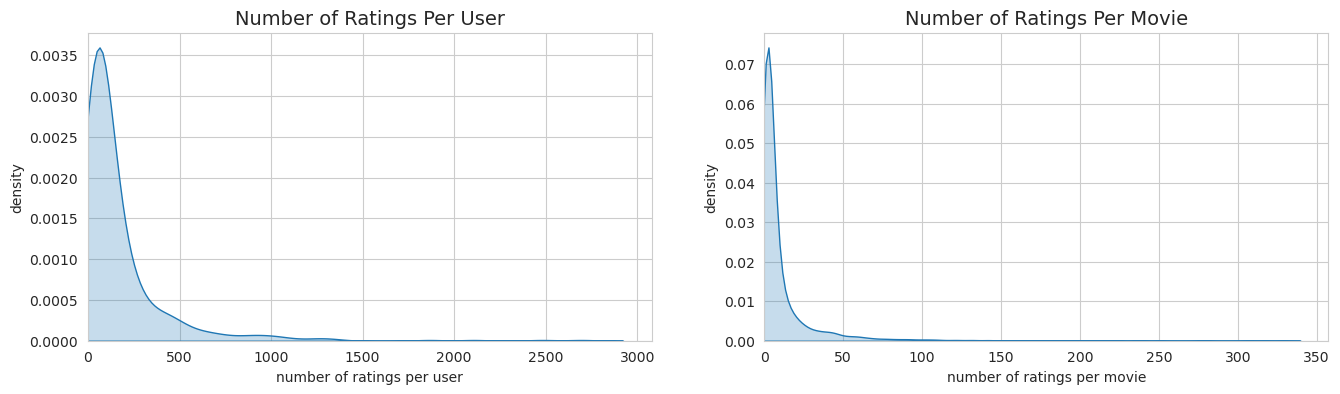

In [29]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
sns.kdeplot(n_rating_per_user, fill=True)
plt.xlim(0)
plt.title("Number of Ratings Per User", fontsize=14)
plt.xlabel("number of ratings per user")
plt.ylabel("density")
plt.subplot(1, 2, 2)
sns.kdeplot(n_rating_per_movie, fill=True)
plt.xlim(0)
plt.title("Number of Ratings Per Movie", fontsize=14)
plt.xlabel("number of ratings per movie")
plt.ylabel("density")
plt.show()

**Step 5: Item-item Recommendations with k-Nearest Neighbors**

We are going to find the K movies that have the most similar user engagement vectors for movie I .

In [30]:
from sklearn.neighbors import NearestNeighbors


def find_similar_movies(
    mvoie_id, X, movie_mapper, movie_inv_mapper, k, metrics="cosine"
):
    """
    Finds k-nearest neighbours for a given movie id.

    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations

    Output: returns list of k similar movie ID's
    """
    X = X.T
    neighbours_ids = []

    movie_ind = movie_mapper[mvoie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1, -1)
    # use k+1 since kNN output includes the movieId of interest
    knn = NearestNeighbors(n_neighbors=k + 1, algorithm="brute", metric=metrics)
    knn.fit(X)
    neighbours = knn.kneighbors(movie_vec, return_distance=False)
    for i in range(0, k):
        n = neighbours.item(i)
        neighbours_ids.append(movie_inv_mapper[n])
    neighbours_ids.pop(0)
    return neighbours_ids

find_similar_movies() takes in a movieId and X matrix, and outputs a list of K
 movies that are similar to the movieId of interest

Let's see how it works in action. We will first create another mapper that maps movieId to title so that our results are interpretable.

In [31]:
similar_movies = find_similar_movies(1, X, movie_mapper, movie_inv_mapper, k=10)
similar_movies

[3114, 480, 780, 260, 356, 364, 1210, 648, 1265]

In [32]:
movie_titles = dict(zip(movies["movieId"], movies["title"]))

movie_id = 1

similar_movies = find_similar_movies(1, X, movie_mapper, movie_inv_mapper, k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watch {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watch Toy Story (1995):
Toy Story 2 (1999)
Jurassic Park (1993)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode IV - A New Hope (1977)
Forrest Gump (1994)
Lion King, The (1994)
Star Wars: Episode VI - Return of the Jedi (1983)
Mission: Impossible (1996)
Groundhog Day (1993)


The results above show the 10 movies that are most similar to Toy Story. Most movies in this list are family movies from the 1990s, which seems pretty reasonable. Note that these recommendations are based solely on user-item ratings. Movie features such as genres are not used in this approach.

You can also play around with the kNN distance metric and see what results you would get if you use "manhattan" or "euclidean" instead of "cosine".

In [33]:
movie_titles = dict(zip(movies["movieId"], movies["title"]))

movie_id = 1

similar_movies = find_similar_movies(
    1, X, movie_mapper, movie_inv_mapper, k=10, metrics="euclidean"
)
movie_title = movie_titles[movie_id]

print(f"Because you watch {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watch Toy Story (1995):
Toy Story 2 (1999)
Mission: Impossible (1996)
Independence Day (a.k.a. ID4) (1996)
Bug's Life, A (1998)
Nutty Professor, The (1996)
Willy Wonka & the Chocolate Factory (1971)
Babe (1995)
Groundhog Day (1993)
Mask, The (1994)


In [34]:
movie_titles = dict(zip(movies["movieId"], movies["title"]))

movie_id = 1

similar_movies = find_similar_movies(
    1, X, movie_mapper, movie_inv_mapper, k=10, metrics="manhattan"
)
movie_title = movie_titles[movie_id]

print(f"Because you watch {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watch Toy Story (1995):
Toy Story 2 (1999)
Bug's Life, A (1998)
Groundhog Day (1993)
Nutty Professor, The (1996)
Willy Wonka & the Chocolate Factory (1971)
Mission: Impossible (1996)
Babe (1995)
Monsters, Inc. (2001)
Toy Story 3 (2010)


In [35]:
similar_movies

[3114, 2355, 1265, 788, 1073, 648, 34, 4886, 78499]

In [38]:
movie_titles = dict(zip(movies["movieId"], movies["title"]))

movie_id = 648

similar_movies = find_similar_movies(
    1, X, movie_mapper, movie_inv_mapper, k=10, metrics="cosine"
)
movie_title = movie_titles[movie_id]

print(f"Because you watch {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watch Mission: Impossible (1996):
Toy Story 2 (1999)
Jurassic Park (1993)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode IV - A New Hope (1977)
Forrest Gump (1994)
Lion King, The (1994)
Star Wars: Episode VI - Return of the Jedi (1983)
Mission: Impossible (1996)
Groundhog Day (1993)


***Step 6: Handling the cold-start problem***

Collaborative filtering relies solely on user-item interactions within the utility matrix. The issue with this approach is that brand new users or items with no iteractions get excluded from the recommendation system. This is called the cold start problem. Content-based filtering is a way to handle this problem by generating recommendations based on user and item features.

First, we need to convert the genres column into binary features. Each genre will have its own column in the dataframe, and will be populated with 0 or 1.

In [39]:
n_movies = movies["movieId"].nunique()
print(f"There are {n_movies} unique movies in our movies dataset.")

There are 9742 unique movies in our movies dataset.


In [41]:
genres = set(g for G in movies["genres"] for g in G)

for g in genres:
    movies[g] = movies.genres.transform(lambda x: int(g in x))

movies_genres = movies.drop(columns=["movieId", "title", "genres"])

In [44]:
movies_genres.head()

,Comedy,Adventure,Drama,Thriller,(no genres listed),IMAX,Action,Horror,Musical,Sci-Fi,Fantasy,Crime,Documentary,Film-Noir,Western,War,Romance,Mystery,Animation,Children
0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1
1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [45]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(movies_genres, movies_genres)
print(f"Dimensions of our genres cosine similiarity matrix : {cosine_sim.shape}")

Dimensions of our genres cosine similiarity matrix : (9742, 9742)


In [46]:
cosine_sim

array([[1.        , 0.77459667, 0.31622777, ..., 0.        , 0.31622777,
        0.4472136 ],
       [0.77459667, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.31622777, 0.        , 1.        , ..., 0.        , 0.        ,
        0.70710678],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.31622777, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.4472136 , 0.        , 0.70710678, ..., 0.        , 0.        ,
        1.        ]])

As expected, after passing the movie_genres dataframe into the cosine_similarity() function, we get a cosine similarity matrix of shape 

<math xmlns="http://www.w3.org/1998/Math/MathML">
  <mo stretchy="false">(</mo>
  <msub>
    <mi>n</mi>
    <mrow data-mjx-texclass="ORD">
      <mtext>movies</mtext>
    </mrow>
  </msub>
  <mo>,</mo>
  <msub>
    <mi>n</mi>
    <mrow data-mjx-texclass="ORD">
      <mtext>movies</mtext>
    </mrow>
  </msub>
  <mo stretchy="false">)</mo>
</math>

This matrix is populated with values between 0 and 1 which represent the degree of similarity between movies along the x and y axes.

**Creating a movie finder function**

Let's say we want to get recommendations for movies that are similar to Jumanji. To get results from our recommender, we need to know the exact title of a movie in our dataset.

In our dataset, Jumanji is actually listed as 'Jumanji (1995)'. If we misspell Jumanji or forget to include its year of release, our recommender won't be able to identify which movie we're interested in.

To make our recommender more user-friendly, we can use a Python package called fuzzywuzzy which will find the most similar title to a string that you pass in. Let's create a function called movie_finder() which take advantage of fuzzywuzzy's string matching algorithm to get the most similar title to a user-inputted string.

In [51]:
from fuzzywuzzy import process


def movie_finder(title):
    all_titles = movies["title"].tolist()
    closest_match = process.extractOne(title, all_titles)
    return closest_match[0]

In [52]:
title = movie_finder("juminji")
title

'Jumanji (1995)'

To get relevant recommendations for Jumanji, we need to find its index in the cosine simialrity matrix. To identify which row we should be looking at, we can create a movie index mapper which maps a movie title to the index that it represents in our matrix.

Let's create a movie index dictionary called movie_idx where the keys are movie titles and values are movie indices:

In [53]:
movie_idx = dict(zip(movies["title"], list(movies.index)))
idx = movie_idx[title]
print(f"Movie index for jumanji :{idx}")

Movie index for jumanji :1


Using this handy movie_idx dictionary, we know that Jumanji is represented by index 1 in our matrix. Let's get the top 10 most similar movies to Jumanji.

In [67]:
n_recommendations = 10
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1 : (n_recommendations + 1)]
similar_movies = [i[0] for i in sim_scores]

similar_movies is an array of indices that represents Jumanji's top 10 recommendations. We can get the corresponding movie titles by either creating an inverse movie_idx mapper or using iloc on the title column of the movies dataframe.

In [69]:
print(f"Because you watched {title}:")
movies["title"].iloc[similar_movies]

Because you watched Jumanji (1995):


53                     Indian in the Cupboard, The (1995)
109                     NeverEnding Story III, The (1994)
767                       Escape to Witch Mountain (1975)
1514            Darby O'Gill and the Little People (1959)
1556                                  Return to Oz (1985)
1617                        NeverEnding Story, The (1984)
1618    NeverEnding Story II: The Next Chapter, The (1...
1799                        Santa Claus: The Movie (1985)
3574    Harry Potter and the Sorcerer's Stone (a.k.a. ...
6075    Chronicles of Narnia: The Lion, the Witch and ...
Name: title, dtype: object

Cool! These recommendations seem pretty relevant and similar to Jumanji. The first 5 movies are family-friendly films from the 90s.

We can test our recommender further with other movie titles. For your convenience, let's package the steps into a single function which takes in the movie title of interest and number of recommendations.

In [75]:
def get_content_based_recommendations(title_string, n_recommendations=10):
    title = movie_finder(title_string)
    idx = movie_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1 : (n_recommendations + 1)]
    similar_movies = [i[0] for i in sim_scores]
    print(f"Because you watched {title}:")
    print(movies["title"].iloc[similar_movies])

In [81]:
get_content_based_recommendations("toy story", 5)

Because you watched Toy Story (1995):
1706                                       Antz (1998)
2355                                Toy Story 2 (1999)
2809    Adventures of Rocky and Bullwinkle, The (2000)
3000                  Emperor's New Groove, The (2000)
3568                             Monsters, Inc. (2001)
Name: title, dtype: object


**Step 7: Dimensionality Reduction with Matrix Factorization (advanced)**

Matrix factorization (MF) is a linear algebra technique that can help us discover latent features underlying the interactions between users and movies. These latent features give a more compact representation of user tastes and item descriptions. MF is particularly useful for very sparse data and can enhance the quality of recommendations. The algorithm works by factorizing the original user-item matrix into two factor matrices:

user-factor matrix (n_users, k)
item-factor matrix (k, n_items)
We are reducing the dimensions of our original matrix into "taste" dimensions. We cannot interpret what each latent feature 
 represents. However, we could imagine that one latent feature may represent users who like romantic comedies from the 1990s, while another latent feature may represent movies which are independent foreign language films.

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <msub>
    <mi>X</mi>
    <mrow data-mjx-texclass="ORD">
      <mi>m</mi>
      <mi>n</mi>
    </mrow>
  </msub>
  <mo>&#x2248;</mo>
  <msub>
    <mi>P</mi>
    <mrow data-mjx-texclass="ORD">
      <mi>m</mi>
      <mi>k</mi>
    </mrow>
  </msub>
  <mo>&#xD7;</mo>
  <msubsup>
    <mi>Q</mi>
    <mrow data-mjx-texclass="ORD">
      <mi>n</mi>
      <mi>k</mi>
    </mrow>
    <mi>T</mi>
  </msubsup>
  <mo>=</mo>
  <mrow data-mjx-texclass="ORD">
    <mover>
      <mi>X</mi>
      <mo stretchy="false">^</mo>
    </mover>
  </mrow>
</math>

![image desc](https://raw.githubusercontent.com/topspinj/tmls-2020-recommender-workshop/c0295cda1853a701844f825b59d7557b32d78f4d//images/matrix_factorization.png)

In [82]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=20, n_iter=10)
Q = svd.fit_transform(X.T)
Q.shape

(9724, 20)

In [103]:
movie_id = 1
similar_movies = find_similar_movies(
    movie_id, Q.T, movie_mapper, movie_inv_mapper, metrics="cosine", k=10
)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Home Alone (1990)
Jurassic Park (1993)
Aladdin (1992)
Back to the Future (1985)
Willy Wonka & the Chocolate Factory (1971)
Forrest Gump (1994)
Groundhog Day (1993)
Star Wars: Episode IV - A New Hope (1977)
Princess Bride, The (1987)
